In [1]:
from os import path, mkdir
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim import SGD
import matplotlib.pyplot as plt
from time import time

base = "/content/drive/MyDrive/NLP100/ch08"

fp_train = "70/train.csv"
fp_valid = "70/valid.csv"
df_train = pd.read_csv(path.join(base, fp_train), index_col=0)
df_valid = pd.read_csv(path.join(base, fp_valid), index_col=0)
df_train.head()

,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
311098,RPT-Fitch Updates EMEA Consumer ABS Rating Cri...,http://in.reuters.com/article/2014/06/24/fitch...,Reuters,0,d3tIMfB2mg-9MZM4G_jGTEiRVl3jM,in.reuters.com,1403633888597,-0.001314,0.037862,-0.026672,0.023646,-0.081309,0.057292,0.020793,-0.004089,0.082174,-0.002248,-0.022980,0.068644,0.098045,-0.021500,-0.184367,-0.066833,0.187785,0.045003,-0.075684,0.020335,0.080343,0.133657,-0.060649,0.177368,0.058131,0.041290,-0.068349,0.165202,0.094462,0.060148,-0.175133,-0.007964,-0.023811,...,0.129374,-0.045410,-0.030120,-0.029256,0.085144,0.040588,-0.081685,-0.098497,0.092773,-0.120480,-0.068659,0.059037,-0.118296,-0.065590,-0.036647,0.029958,0.034060,0.033641,0.071494,0.032679,-0.137390,0.013021,0.029460,-0.039007,-0.014064,0.028880,-0.003194,0.052385,-0.021932,0.113113,0.085225,0.070714,-0.038605,0.124247,0.043162,-0.029622,0.018305,0.085449,0.041219,-0.043620
49198,"Gurlitt Wants to Return Nazi-Looted Art, Suedd...",http://www.businessweek.com/news/2014-03-26/gu...,Businessweek,2,dWeC4g3bvX-bI6MKAcxt43Jp7MzSM,www.businessweek.com,1395886231417,0.119507,0.048203,-0.051575,-0.014130,0.052837,0.131592,0.029251,-0.041846,0.007202,0.044903,-0.120361,0.073059,-0.026611,0.071785,-0.028809,-0.058235,-0.035706,0.040100,-0.049072,0.029297,0.088989,0.110657,0.072845,0.093506,-0.072479,0.039246,-0.003685,0.005188,-0.049683,0.103149,0.052261,-0.071106,-0.093994,...,0.071457,0.065735,0.001794,0.118408,0.084869,0.080444,-0.080811,-0.006203,0.047668,0.095886,0.075562,0.032227,0.133545,0.013916,0.089539,0.061638,-0.037537,-0.036049,0.010513,-0.037415,-0.046600,0.061676,-0.122375,0.077362,0.090454,0.049744,-0.016205,0.113892,0.044678,0.026615,-0.096585,-0.046362,-0.111450,0.115601,0.027069,0.017731,-0.066109,-0.092987,0.049255,-0.078003
410578,"UPDATE 1-Fairfax Financial, CEO probed over po...",http://in.reuters.com/article/2014/08/01/fairf...,Reuters,0,d6s61cXf9rASExMO8inpkRujc9VTM,in.reuters.com,1406929609070,-0.027208,0.007894,-0.018816,-0.117791,-0.013855,0.014296,0.008413,0.019104,0.171115,0.043545,-0.152289,0.039632,0.042263,-0.009230,-0.092692,-0.008898,-0.015686,0.031908,0.006592,-0.047694,-0.029080,-0.003977,0.071289,-0.047387,0.060900,-0.035598,-0.081624,0.043403,-0.034064,0.048928,0.028076,0.047011,-0.118218,...,0.035502,0.011210,0.037638,-0.024943,0.013970,0.076586,-0.117757,0.025011,-0.058146,0.016303,-0.011529,0.053528,0.036892,-0.090074,-0.054633,-0.021145,-0.057997,-0.005412,0.050978,0.136827,-0.101793,0.112632,-0.084054,0.044612,0.154107,0.002821,-0.094137,0.091295,0.033488,0.004069,-0.004666,-0.019070,-0.127279,0.066745,-0.100342,-0.027534,-0.004937,0.060760,0.024204,-0.030084
270668,Angelina Jolie - Angelina Jolie Will Not Tight...,http://www.contactmusic.com/story/angelina-jol...,Contactmusic.com,2,d7SbUKanRaD34YMwE64lo09d_qCnM,www.contactmusic.com,1401828902205,0.041495,0.023817,-0.139968,0.066092,-0.128230,0.041222,-0.031513,-0.062556,0.033259,0.084491,0.055627,-0.051058,-0.008244,0.054617,-0.093083,0.002742,-0.010099,0.032428,-0.126578,-0.036814,0.010050,0.040527,0.195050,0.106788,-0.025531,-0.112279,0.036545,0.065195,0.045805,-0.118972,-0.081160,-0.038743,-0.142465,...,-0.003488,0.148945,0.032250,0.036339,0.088435,0.147010,-0.264986,0.080181,-0.051074,-0.023569,0.065317,0.029278,0.004169,0.111516,0.115882,-0.045206,0.177396,-0.017759,-0.059991,-0.054676,0.000347,-0.111197,-0.069393,0.131484,0.029644,0.067834,-0.131770,-0.111361,0.016447,0.056566,-0.142315,0.059533,-0.078726,0.063308,-0.031076,-0.083947,-0.062951,-0.072796,-0.045157,0.098994
301656,Patent Officials Cancel the Washington Redskin...,http://www.businessweek.com/articles/2014-

In [2]:
X_train = torch.tensor(df_train[[str(r) for r in range(300)]].values.astype("float32"))
y_train = torch.tensor(df_train["CATEGORY"].values.astype("int"))
X_valid = torch.tensor(df_valid[[str(r) for r in range(300)]].values.astype("float32"))
y_valid = torch.tensor(df_valid["CATEGORY"].values.astype("int"))
print(X_train[:5])
print(y_train[:5])

tensor([[-0.0013,  0.0379, -0.0267,  ...,  0.0854,  0.0412, -0.0436],
        [ 0.1195,  0.0482, -0.0516,  ..., -0.0930,  0.0493, -0.0780],
        [-0.0272,  0.0079, -0.0188,  ...,  0.0608,  0.0242, -0.0301],
        [ 0.0415,  0.0238, -0.1400,  ..., -0.0728, -0.0452,  0.0990],
        [ 0.0851,  0.0319,  0.1310,  ..., -0.0540,  0.0016,  0.0300]])
tensor([0, 2, 0, 2, 0])


In [3]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(300, 4, bias=False)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    y = self.linear(x)
    y = self.softmax(y)
    return y

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"device: {device}")

device: cuda


In [4]:
learning_rate = 0.001
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
loss_fn = nn.CrossEntropyLoss()

times = []
corrects = []
for batch_size in batch_sizes:
  num_workers = 2
  dataset_train = [(X_i, y_i) for X_i, y_i in zip(X_train, y_train)]
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  dataset_valid = [(X_i, y_i) for X_i, y_i in zip(X_valid, y_valid)]
  dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers)

  model = Model().to(device)
  optimizer = SGD(model.parameters(), lr=learning_rate)

  start_time = time()
  for epoch in range(100):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    size = len(dataloader_train.dataset)
    for batch, (X, y) in enumerate(dataloader_train):
      X, y = X.to(device), y.to(device)
      loss = loss_fn(model(X), y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if batch % 1000 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    size = len(dataloader_valid.dataset)
    loss, correct = 0, 0
    with torch.no_grad():
      for X, y in dataloader_valid:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {loss:>8f} \n")
  
  end_time = time()
  times.append((end_time - start_time) / 100)
  corrects.append(correct)

ストリーミング出力は最後の 5000 行に切り捨てられました。
loss: 1.169475  [ 8000/10672]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.306078 

Epoch 14
-------------------------------
loss: 1.152688  [    0/10672]
loss: 1.189949  [ 4000/10672]
loss: 1.087766  [ 8000/10672]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.303260 

Epoch 15
-------------------------------
loss: 1.431790  [    0/10672]
loss: 1.176172  [ 4000/10672]
loss: 1.111436  [ 8000/10672]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.300603 

Epoch 16
-------------------------------
loss: 1.106552  [    0/10672]
loss: 1.089583  [ 4000/10672]
loss: 1.326578  [ 8000/10672]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.298285 

Epoch 17
-------------------------------
loss: 1.146467  [    0/10672]
loss: 1.121264  [ 4000/10672]
loss: 1.044202  [ 8000/10672]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.295824 

Epoch 18
-------------------------------
loss: 1.174982  [    0/10672]
loss: 1.197872  [ 4000/10672]
loss: 1.208147  [ 8000/10672]
Test Error: 
 Accuracy:

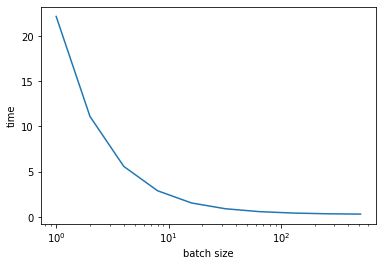

In [5]:
plt.plot(batch_sizes, times)
plt.xlabel("batch size")
plt.ylabel("time")
plt.xscale("log")
plt.show()

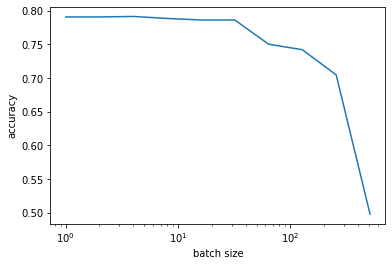

In [6]:
plt.plot(batch_sizes, corrects)
plt.xlabel("batch size")
plt.ylabel("accuracy")
plt.xscale("log")
plt.show()